In [141]:
'''
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python
'''


'\n!pip install segmentation-models-pytorch\n!pip install -U git+https://github.com/albumentations-team/albumentations\n!pip install --upgrade opencv-contrib-python\n'

In [179]:

#!git clone https://github.com/parth1620/Road_seg_dataset.git


In [180]:
import os
data_path="C:/Users/jalil/OneDrive/Desktop/pytorch/aerial_segmen/Road_seg_dataset/"

In [181]:
import torch 
import cv2 as cv

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

In [205]:
CSV_File = "Road_seg_dataset/train.csv"
DEVICE= 'cuda'
BATCH_SIZE = 2
IMG_SIZE = 512
ENCODER = 'timm-efficientnet-b0'
weight = 'imagenet'

In [206]:
df = pd.read_csv(CSV_File)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [207]:
indx = 9
row= df.iloc[indx]


image_path = data_path+ row.images
mask_path = data_path+row.masks
image=cv.imread(image_path)


image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
mask = cv.imread(mask_path,cv.IMREAD_GRAYSCALE)




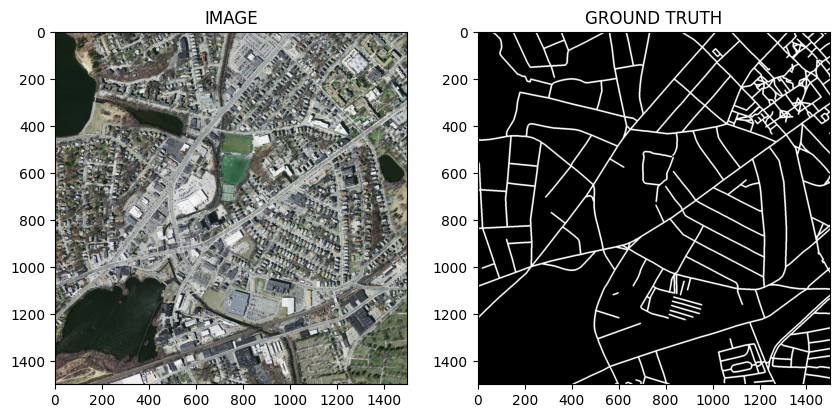

In [208]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [209]:
train_df,valid_df=train_test_split(df,test_size=0.25,random_state=42)

In [210]:
len(valid_df)

50

In [211]:
len(train_df)

149

Augmnentation Function

In [212]:
import albumentations as A

def get_train_augs():
    return A.Compose([
        A.Resize(IMG_SIZE,IMG_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5)
    ])

def get_valid_augs():
    return A.Compose([
        A.Resize(IMG_SIZE,IMG_SIZE)
    ])


Creating custom dataset

In [235]:
from torch.utils.data import Dataset

class Segmentation_Dataset(Dataset):
    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, indx):
        row = self.df.iloc[indx]

        image_path = data_path + row.images
        mask_path = data_path + row.masks
        image = cv.imread(image_path)

        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)   # (h,w)
        mask = np.expand_dims(mask, axis=-1)  # added new dim for channel (h,w,c)
        if self.augmentations:
            data = self.augmentations(image=image, mask=mask)
            image = data['image']
            mask = data['mask']
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)  # convert to (c,w,h)
        mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)
        image = torch.Tensor(image) / 255.0  # become tensor
        mask = torch.round(torch.Tensor(mask))
        return image, mask


In [214]:
train_set = Segmentation_Dataset(df=train_df,augmentations=get_train_augs())

valid_set = Segmentation_Dataset(valid_df,get_valid_augs())

In [215]:
print(len(train_set))
print(len(valid_set))

149
50


torch.Size([1, 512, 512])


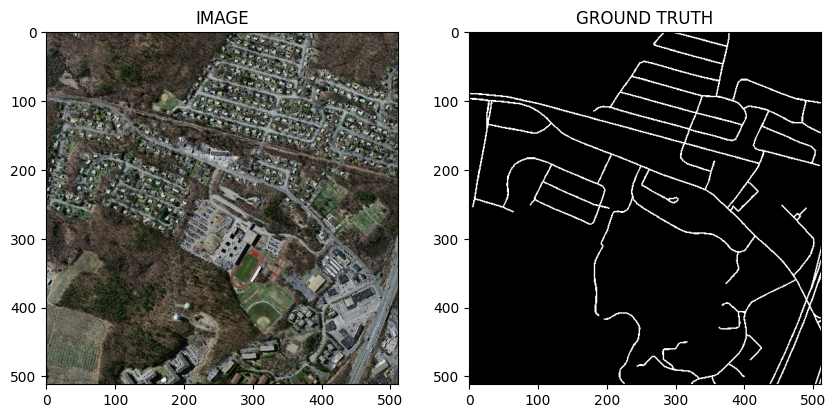

In [236]:
indx = 9

image,mask =train_set[indx]
print(mask.shape)
helper.show_image(image,mask)

Lets load data into matches

In [237]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set,batch_size=BATCH_SIZE,shuffle=True)
valid_loader = DataLoader(valid_set,batch_size=BATCH_SIZE)


In [267]:
print(f"Total number ofin each batch for trainloader: {len(train_loader)}")

Total number ofin each batch for trainloader: 75


Segmentation_MODEL

In [238]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from torch  import nn

In [268]:
class Segmentation_Model(nn.Module):
    def __init__(self):
        super(Segmentation_Model,self).__init__()
        self.backbone = smp.Unet(
            encoder_name= ENCODER  ,#"resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
            encoder_weights=weight,     # use `imagenet` pre-trained weights for encoder initialization
            in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
            classes=1,
            activation=None                      # model output channels (number of classes in your dataset)
        )

    def forward(self,images,masks=None):
        logits = self.backbone(images)
        if masks != None:
            return logits, DiceLoss(mode='binary')(logits,masks)+nn.BCEWithLogitsLoss(logits,masks)
        
        return logits

In [269]:
torch.manual_seed(42)

model = Segmentation_Model()
model.to(DEVICE)

In [270]:

def train_step(model,data_loader,optimizer):
    #model.to(DEVICE)
    model.train()
    total_loss =0.0
    
    for images,masks in tqdm(data_loader):
        #images=torch.unsqueeze(images,dim=0).to(DEVICE)
        images=images.to(DEVICE)
        #masks=torch.unsqueeze(masks,dim=0).to(DEVICE)
        masks=masks.to(DEVICE)
        optimizer.zero_grad()
        logits, loss = model(images,masks)
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()
    return total_loss/len(data_loader)

def eval_mode(model,data_load):
    #model.to(DEVICE)
    model.eval()
    total_loss =0
    
    with torch.no_grad():
        for images,masks in tqdm(data_load):
            #images=torch.unsqueeze(images,dim=0).to(DEVICE)
            images=images.to(DEVICE)
            #masks=torch.unsqueeze(masks,dim=0).to(DEVICE)
            masks = masks.to(DEVICE)
            logits, loss = model(images,masks)
            total_loss+=loss.item()
        return total_loss/len(data_load)

In [265]:
torch.manual_seed(42)
model=model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
best_loss = np.Inf
EPOCHS = 8
for epoch in range(EPOCHS):
    train_loss = train_step(model=model,data_loader=train_loader,optimizer=optimizer)
    valid_loss= eval_mode(model=model,data_load=valid_loader)
    if valid_loss<best_loss:
        torch.save(model.state_dict(),'best_model.pt')
        print("Saved-model")
        best_loss = valid_loss

    print(f"Epoch: {epoch+1}--Train_loss: {train_loss}---Valid loss: {valid_loss}")

  0%|          | 0/75 [00:00<?, ?it/s]


RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [233]:
indx=17
model.load_state_dict(torch.load('best_model.pt'))
image,mask = valid_set[indx]
logits_mask=model(image.to(DEVICE).unsqueeze(0))
pred_mask=torch.sigmoid(logits_mask)
pred_mask=(pred_mask>0.3)*1.0

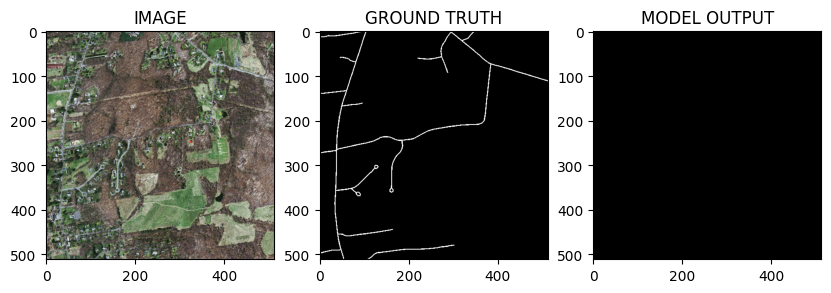

In [234]:
helper.show_image(image,mask,pred_mask.detach().cpu().squeeze(0))